In [1]:
import sys

sys.path.insert(0, "/Users/jtlaune/Notes/notes/code_notebooks/")
sys.path.insert(0,"/Users/jtlaune/athena/vis/python/")
import athena_read
from mpl_styles import analytic
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import scipy as sp
import numpy as np
import os
import yt

accRunDir = "/Users/jtlaune/runs/JTrunII_Acc/"
noAccRunDir = "/Users/jtlaune/runs/JTrunII_noAcc/"
%matplotlib inline
mpl.rcParams["text.usetex"] = True

# Mesh calculations

In [66]:
rH = (1e-4/3)**(1./3)
rS = 0.00032
Nr1 = 256
Np1 = 1536
Lr = 1.2
Lp = 2*np.pi

dr1 = Lr/Nr1
dp1 = Lp/Np1
dr4 = dr1/2**4
dp4 = dp1/2**4
dr6 = dr1/2**6
dp6 = dp1/2**6

rH1dr = rH/dr1
rH4dr = rH/dr4
rH6dr = rH/dr6

rH1dp = rH/dp1
rH4dp = rH/dp4
rH6dp = rH/dp6

rS1dr = rS/dr1
rS4dr = rS/dr4
rS6dr = rS/dr6

rS1dp = rS/dp1
rS4dp = rS/dp4
rS6dp = rS/dp6

print("delta")
print(dr1,dr4,dr6)
print(dp1,dp4,dp6)

print("rH")
print(rH1dr,rH4dr,rH6dr)
print(rH1dp,rH4dp,rH6dp)

print("rS")
print(rS1dr,rS4dr,rS6dr)
print(rS1dp,rS4dp,rS6dp)


delta
0.0046875 0.00029296875 7.32421875e-05
0.0040906154343617095 0.00025566346464760684 6.391586616190171e-05
rH
6.865702290528925 109.8512366484628 439.4049465938512
7.867515292812191 125.88024468499506 503.52097873998025
rS
0.06826666666666667 1.0922666666666667 4.369066666666667
0.0782278376285284 1.2516454020564545 5.006581608225818


# Zoomed in plots (1.1 $R_H$)

In [3]:
def get_bbox(x1min,x1max,x2min,x2max,data_dict,filename):
    strobe = 1
    x1min_ind = np.where(data_dict["x1v"]>x1min)[0][0]
    x1max_ind = np.where(data_dict["x1v"]>x1max)[0][0]
    x2min_ind = np.where(data_dict["x2v"]>x2min)[0][0]
    x2max_ind = np.where(data_dict["x2v"]>x2max)[0][0]

    rho = data_dict["dens"][0,:,:]
    vr = data_dict["mom1"][0,::1,::1]/data_dict["dens"][0,::1,::1]
    vth = data_dict["mom2"][0,::1,::1]/data_dict["dens"][0,::1,::1]

    coordsr, coordsth = data_dict["x1v"], data_dict["x2v"]
    #coordsx = coordsr*np.cos(coordsth)
    #coordsy = coordsr*np.sin(coordsth)

    rc = coordsr[x1min_ind:x1max_ind:strobe]
    thc = coordsth[x2min_ind:x2max_ind:strobe]
    rhoc = rho[x2min_ind:x2max_ind:strobe,x1min_ind:x1max_ind:strobe]
    vrc = vr[x2min_ind:x2max_ind:strobe,x1min_ind:x1max_ind:strobe]
    vthc = vth[x2min_ind:x2max_ind:strobe,x1min_ind:x1max_ind:strobe]

    np.savez(filename,rho=rhoc,vr=vrc,vth=vthc,r=rc,th=thc)

def get_cartInterpVels(data,nx,ny):


    xg = np.linspace(data["r"][0],data["r"][-1]*np.cos(data["th"][0]),nx)
    yg = np.linspace(data["r"][0]*data["th"][0],data["r"][0]*data["th"][-1],ny)
    xg, yg = np.meshgrid(xg,yg)
    xg = xg.flatten()
    yg = yg.flatten()

    rc, thc = np.meshgrid(data["r"],data["th"])
    rc = rc.flatten()
    thc = thc.flatten()
    xc = (rc*np.cos(thc)).flatten()
    yc = (rc*np.sin(thc)).flatten()
    vrc = data["vr"].flatten()
    vthc = data["vth"].flatten()

    xdotc = vrc*np.cos(thc) - rc*np.sin(thc)*vthc
    ydotc = vrc*np.sin(thc) + rc*np.cos(thc)*vthc

    xdotg = sp.interpolate.griddata((xc,yc), xdotc, (xg,yg))
    ydotg = sp.interpolate.griddata((xc,yc), ydotc, (xg,yg))
    return(xg.reshape(nx,ny),yg.reshape(nx,ny),xdotg.reshape(nx,ny),ydotg.reshape(nx,ny)) 


In [4]:
iout = 260
accFname = accRunDir+f"{iout:05}_large_chunk.npz"
noAccFname = noAccRunDir+f"{iout:05}_large_chunk.npz" 

In [5]:
dataAcc = athena_read.athdf(accRunDir+f"ppd_cyl.out1.{iout:05}.athdf")
dataNoAcc = athena_read.athdf(noAccRunDir+f"ppd_cyl.out1.{iout:05}.athdf")
get_bbox(1-1.1*0.032,1+1.1*0.032,-0.032*1.1,0.032*1.1,dataAcc,accFname)
get_bbox(1-1.1*0.032,1+1.1*0.032,-0.032*1.1,0.032*1.1,dataNoAcc,noAccFname)

In [6]:
dataAcc = np.load(accFname)
dataNoAcc = np.load(noAccFname)

In [7]:
interpx,interpy,interpxdot,interpydot = get_cartInterpVels(dataAcc, 500, 500)

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_36677/233792384.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")


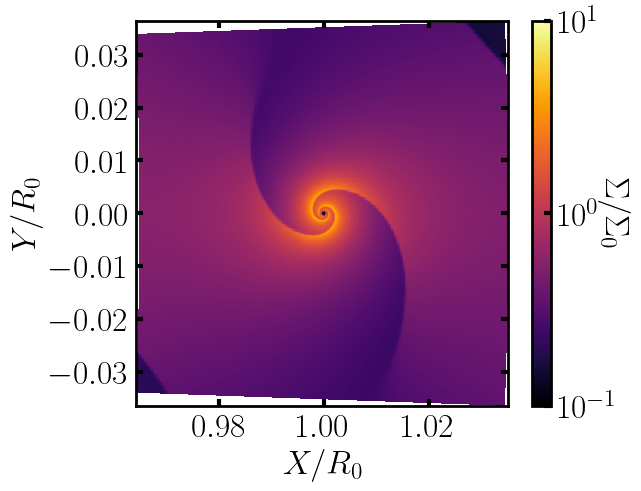

In [9]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    Sig0 = 0.001
    RR,TT = np.meshgrid(dataAcc["r"],dataAcc["th"])
    cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")
    #ax.streamplot(interpx,interpy,interpxdot,interpydot,linewidth=1,color="c")
    cb = plt.colorbar(cs)
    cb.ax.set_ylabel(r"$\Sigma/\Sigma_0$",rotation=270,labelpad=10)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.set_xlabel(r"$X/R_0$")
    ax.set_ylabel(r"$Y/R_0$")
    fig.savefig("/Users/jtlaune/Desktop/Accreting1_1RH.png",dpi=300,bbox_inches="tight")

In [28]:
interpx,interpy,interpxdot,interpydot = get_cartInterpVels(dataNoAcc, 500, 500)

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_35083/385680116.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataNoAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")


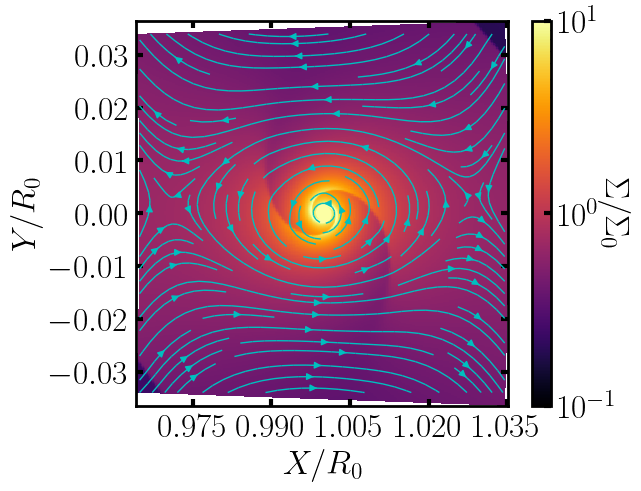

In [29]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    Sig0 = 0.001
    RR,TT = np.meshgrid(dataNoAcc["r"],dataNoAcc["th"])
    cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataNoAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")
    ax.streamplot(interpx,interpy,interpxdot,interpydot,linewidth=1,color="c")
    cb = plt.colorbar(cs)
    cb.ax.set_ylabel(r"$\Sigma/\Sigma_0$",rotation=270,labelpad=10)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.set_xlabel(r"$X/R_0$")
    ax.set_ylabel(r"$Y/R_0$")
    fig.savefig("/Users/jtlaune/Desktop/NonAccreting1_1RH.png",dpi=300,bbox_inches="tight")

# Accretion rate (time averaged)

In [5]:
strobe = 1
dataAcc = np.loadtxt(accRunDir + "ppd_cyl.hst")[::strobe,:]
dataNoAcc = np.loadtxt(noAccRunDir + "ppd_cyl.hst")[::strobe,:]

In [117]:
def runningTimeAverage(x,dt,N):
    if N%2==0: raise Warning("N must be odd")
    y = np.zeros((len(x)))
    for ctr in range(len(x)):
        ind1 = int(ctr-(N-1)/2)
        ind2 = int(ctr+(N-1)/2)+1
        if ind1<0: y[ctr] = 0
        elif ind2>len(x): y[ctr] = 0
        else:
            if len(x[ind1:ind2])!=N: raise Warning(f"{(ind1,ind2)}")
            y[ctr] = np.average(x[ind1:ind2]*dt[ind1:ind2])/np.sum(dt[ind1:ind2])
    return(y)

In [124]:
tlim = 260
t=dataNoAcc[:,0]/np.pi/2
it = np.where(t>tlim)[0][0]
dt = dataNoAcc[:it,1]
x = dataNoAcc[:it,-3]
print(len(x))
timeAvg = runningTimeAverage(x, dt, 11)

33397440


In [125]:
np.savez(noAccRunDir+"timeAveragedAccRate.npz",timeAvg=timeAvg)

In [120]:
timeAvg[:10]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.46838247e-08, 2.90822786e-08, 3.25097248e-08,
       3.40219992e-08, 3.55581318e-08])

In [3]:
noAccTimeAvgAcc = np.load(noAccRunDir+"timeAveragedAccRate.npz")
accTimeAvgAcc = np.load(accRunDir+"timeAveragedAccRate.npz")

In [131]:
print(noAccTimeAvgAcc["timeAvg"][0:20])
print(accTimeAvgAcc["timeAvg"][0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46838247e-08 2.90822786e-08 3.25097248e-08
 3.40219992e-08 3.55581318e-08 3.70991329e-08 3.87329824e-08
 4.05664298e-08 4.28631147e-08 4.61646099e-08 4.85157023e-08
 5.10362393e-08 5.32626563e-08 5.54505578e-08 5.74598522e-08]


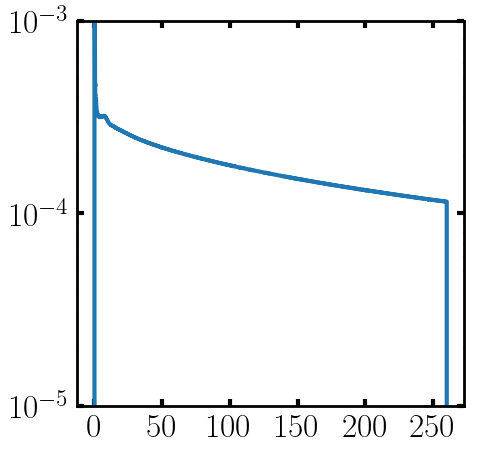

In [7]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots(figsize=(5,5))
    q = 1e-4
    tlim = 260

    t=dataAcc[:,0]/np.pi/2
    it = np.where(t>tlim)[0][0]
    t = t[:it]
    ax.set_ylim(1e-5,1e-3)
    ax.set_yscale("log")
    ax.plot(t,accTimeAvgAcc["timeAvg"][:it]/q)

# Torque plots

In [54]:
strobe = 1
dataAcc = np.loadtxt(accRunDir + "ppd_cyl.hst")[::strobe,:]
dataNoAcc = np.loadtxt(noAccRunDir + "ppd_cyl.hst")[::strobe,:]

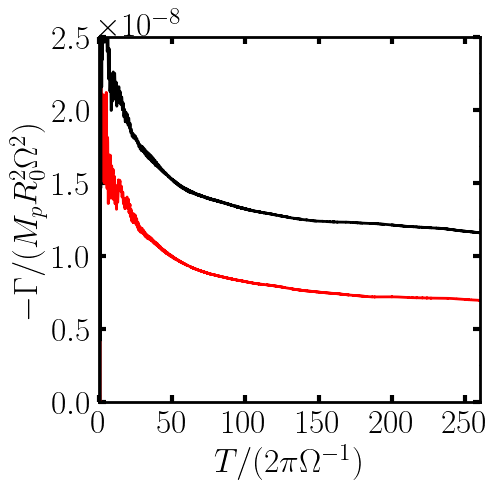

In [24]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots(figsize=(5,5))
    q = 1e-4
    tlim = 260

    t=dataAcc[:,0]/np.pi/2
    it = np.where(t>tlim)[0][0]
    t = t[:it]
    FP_x=dataAcc[:it,-7]
    FP_y=dataAcc[:it,-6]
    Fsgrav_x=dataAcc[:it,-5]
    Fsgrav_y=dataAcc[:it,-4]
    accrate=dataAcc[:it,-3]
    momx_accrate =dataAcc[:it,-2]
    momy_accrate =dataAcc[:it,-1]
    ax.plot(t,-Fsgrav_y,c="r",lw=2,label="Accreting")

    t=dataNoAcc[:,0]/np.pi/2
    it = np.where(t>tlim)[0][0]
    t = t[:it]
    FP_x=dataNoAcc[:it,-7]
    FP_y=dataNoAcc[:it,-6]
    Fsgrav_x=dataNoAcc[:it,-5]
    Fsgrav_y=dataNoAcc[:it,-4]
    accrate=dataNoAcc[:it,-3]
    momx_accrate =dataNoAcc[:it,-2]
    momy_accrate =dataNoAcc[:it,-1]
    ax.plot(t,-Fsgrav_y,c="k",lw=2,label="Softened")
    ax.yaxis.set_minor_locator(ticker.MaxNLocator((10)))

    ax.set_ylim(0,2.5e-8)
    #ax.set_yscale("log")
    ax.set_xlim(0,tlim)
    ax.set_ylabel(r"$-\Gamma/(M_pR_0^2\Omega^2)$")
    ax.set_xlabel(r"$T/(2\pi\Omega^{-1})$")
    fig.tight_layout()

# Larger chunk (interp pcolor & streamplot)

In [20]:
iout = 260
ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")

yt : [WARNING  ] 2023-05-05 22:27:03,318 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-05 22:27:03,319 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-05 22:27:03,319 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-05 22:27:03,320 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-05 22:27:03,349 Parameters: current_time              = 1633.6215
yt : [INFO     ] 2023-05-05 22:27:03,350 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-05 22:27:03,350 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-05 22:27:03,351 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-05 22:27:03,351 Parameters: cosmological_simulation   = 0


yt : [WARNING  ] 2023-05-05 23:05:36,749 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-05 23:05:36,750 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-05 23:05:36,750 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-05 23:05:36,750 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-05 23:05:36,767 Parameters: current_time              = 1633.6215
yt : [INFO     ] 2023-05-05 23:05:36,768 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-05 23:05:36,768 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-05 23:05:36,768 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-05 23:05:36,769 Parameters: cosmological_simulation   = 0


(632832,)


/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_47878/1578534074.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(rr * np.cos(pp), rr * np.sin(pp), densg)


(1000, 1000) (1000, 1000) (1000, 1000) (1000, 1000)


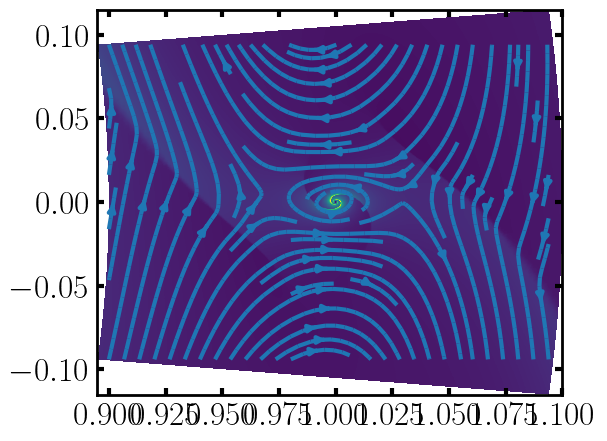

In [42]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")
    dd = ds.all_data()
    print(dd["athena_pp", "dens"].shape)
    rg = np.linspace(0.9, 1.1, 1000)
    pg = np.linspace(-np.pi / 30, np.pi / 30, 1000)
    rr, pp = np.meshgrid(rg, pg)
    densg = sp.interpolate.griddata(
        dd.fcoords[:, :2], dd["athena_pp", "dens"], (rr, pp), method="linear"
    )

    xg = np.linspace(rg[0],rg[-1]*np.cos(pg[0]),1000 )
    yg = np.linspace(rg[0]*np.sin(pg[0]),rg[0]*np.sin(pg[-1]),1000)
    xg,yg = np.meshgrid(xg,yg)
    vrg = sp.interpolate.griddata(
        (dd.fcoords[:, 0]*np.cos(dd.fcoords[:, 1]),dd.fcoords[:, 0]*np.sin(dd.fcoords[:, 1])),
        dd["athena_pp", "mom1"] / dd["athena_pp", "dens"],
        (xg, yg),
        method="linear",
    )
    vpg = sp.interpolate.griddata(
        (dd.fcoords[:, 0]*np.cos(dd.fcoords[:, 1]),dd.fcoords[:, 0]*np.sin(dd.fcoords[:, 1])),
        dd["athena_pp", "mom2"] / dd["athena_pp", "dens"],
        (xg, yg),
        method="linear",
    )

    plt.pcolormesh(rr * np.cos(pp), rr * np.sin(pp), densg)

    xdotg = vrg*(xg/np.sqrt(xg**2+yg**2)) - np.sqrt(xg**2+yg**2)*(yg/np.sqrt(xg**2+yg**2))*vpg
    ydotg = vrg*(yg/np.sqrt(xg**2+yg**2)) + np.sqrt(xg**2+yg**2)*(xg/np.sqrt(xg**2+yg**2))*vpg
    print(xg.shape,yg.shape,xdotg.shape,ydotg.shape)
    plt.streamplot(xg,yg,xdotg,ydotg)
    


In [ ]:
def get_cartInterpVels(data,nx,ny):
    xg = np.linspace(data["r"][0],data["r"][-1]*np.cos(data["th"][0]),nx)
    yg = np.linspace(data["r"][0]*data["th"][0],data["r"][0]*data["th"][-1],ny)
    xg, yg = np.meshgrid(xg,yg)
    xg = xg.flatten()
    yg = yg.flatten()

    rc, thc = np.meshgrid(data["r"],data["th"])
    rc = rc.flatten()
    thc = thc.flatten()
    xc = (rc*np.cos(thc)).flatten()
    yc = (rc*np.sin(thc)).flatten()
    vrc = data["vr"].flatten()
    vthc = data["vth"].flatten()

    xdotc = vrc*np.cos(thc) - rc*np.sin(thc)*vthc
    ydotc = vrc*np.sin(thc) + rc*np.cos(thc)*vthc

    xdotg = sp.interpolate.griddata((xc,yc), xdotc, (xg,yg))
    ydotg = sp.interpolate.griddata((xc,yc), ydotc, (xg,yg))
    return(xg.reshape(nx,ny),yg.reshape(nx,ny),xdotg.reshape(nx,ny),ydotg.reshape(nx,ny)) 


# Mass flux

In [43]:
iout = 260
ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")

yt : [WARNING  ] 2023-05-05 23:09:38,196 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-05 23:09:38,196 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-05 23:09:38,197 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-05 23:09:38,197 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-05 23:09:38,214 Parameters: current_time              = 1633.6215
yt : [INFO     ] 2023-05-05 23:09:38,214 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-05 23:09:38,215 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-05 23:09:38,215 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-05 23:09:38,215 Parameters: cosmological_simulation   = 0


yt : [WARNING  ] 2023-05-05 23:27:22,866 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-05 23:27:22,866 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-05 23:27:22,867 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-05 23:27:22,867 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-05 23:27:22,883 Parameters: current_time              = 1633.6248
yt : [INFO     ] 2023-05-05 23:27:22,884 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-05 23:27:22,889 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-05 23:27:22,895 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-05 23:27:22,899 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-05 23:27:35,632 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-05 23:27:35,632 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-05 23:27:35,633 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-05 23:27:35,633 Assuming 1.0 = 1

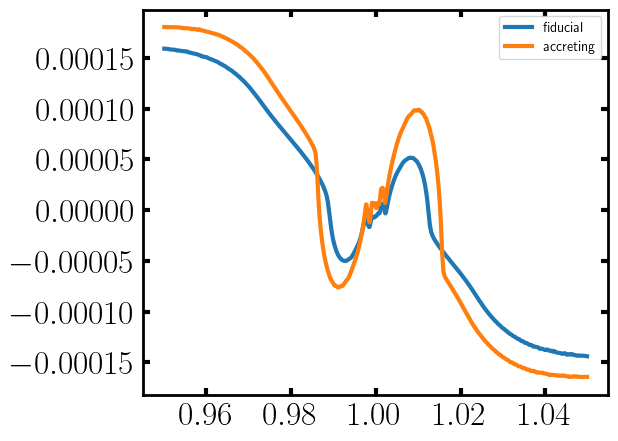

In [55]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    rg = np.linspace(0.95,1.05,1000)
    pg = np.linspace(-np.pi,np.pi,6000)
    rr, pp = np.meshgrid(rg,pg)

    ds = yt.load(noAccRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")
    dd = ds.all_data()
    dd["athena_pp","dens"].shape
    densg = sp.interpolate.griddata(dd.fcoords[:,:2],dd["athena_pp","dens"],(rr,pp),method="linear")
    densg = np.nan_to_num(densg,0)
    vrg = sp.interpolate.griddata(dd.fcoords[:,:2],dd["athena_pp","mom1"]/dd["athena_pp","dens"],(rr,pp),method="linear")
    vrg = np.nan_to_num(vrg,0)
    #ax.plot(rg[2:-2],np.mean(2*np.pi*rg*densg*vrg,axis=0)[2:-2],label=f"fiducial")
    ax.plot(rg[2:-2],np.mean(vrg,axis=0)[2:-2],label=f"fiducial")

    ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")
    dd = ds.all_data()
    dd["athena_pp","dens"].shape
    densg = sp.interpolate.griddata(dd.fcoords[:,:2],dd["athena_pp","dens"],(rr,pp),method="linear")
    densg = np.nan_to_num(densg,0)
    vrg = sp.interpolate.griddata(dd.fcoords[:,:2],dd["athena_pp","mom1"]/dd["athena_pp","dens"],(rr,pp),method="linear")
    vrg = np.nan_to_num(vrg,0)
    #ax.plot(rg[2:-2],np.mean(2*np.pi*rg*densg*vrg,axis=0)[2:-2],label=f"accreting")
    ax.plot(rg[2:-2],np.mean(vrg,axis=0)[2:-2],label=f"accreting")

    ax.legend()

# Gap profile

In [14]:
iout = 260
ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")

yt : [WARNING  ] 2023-05-04 16:23:20,713 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-04 16:23:20,713 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-04 16:23:20,714 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-04 16:23:20,714 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-04 16:23:20,732 Parameters: current_time              = 1633.6215
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: cosmological_simulation   = 0


yt : [WARNING  ] 2023-05-04 16:21:50,801 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-04 16:21:50,802 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-04 16:21:50,802 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-04 16:21:50,803 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-04 16:21:50,823 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-04 16:21:57,336 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-04 16:21:57,337 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-04 16:21:57,337 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-04 16:21:57,337 Assuming 1.0 = 1.0 K
y

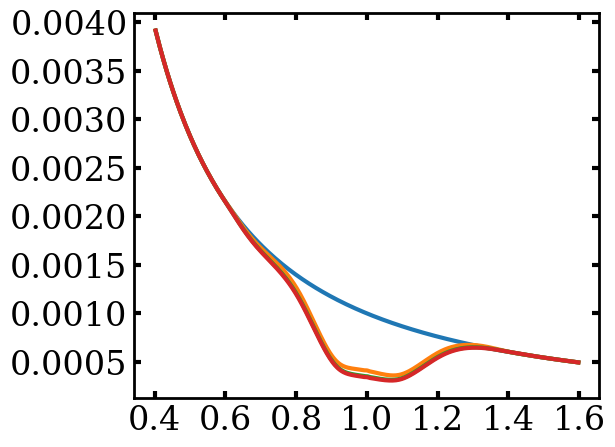

In [11]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")
    dd = ds.all_data()
    dd["athena_pp","dens"].shape
    rg = np.linspace(0.4,1.6,1000)
    pg = np.linspace(-np.pi,np.pi,6000)
    rr, pp = np.meshgrid(rg,pg)
    densg = sp.interpolate.griddata(dd.fcoords[:,:2],dd["athena_pp","dens"],(rr,pp),method="linear")
    densg = np.nan_to_num(densg,0)
    ax.plot(rg[2:-2],np.mean(densg,axis=0)[2:-2],label=f"T={iout} orbits")

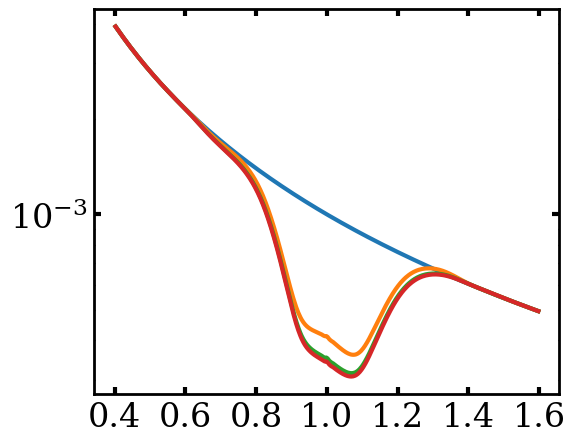

In [13]:
ax.set_yscale("log")
fig

# Torque density profile

In [68]:
iout = 260
ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")

yt : [WARNING  ] 2023-05-07 00:43:30,442 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-07 00:43:30,443 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-07 00:43:30,443 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-07 00:43:30,444 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-07 00:43:30,462 Parameters: current_time              = 1633.6215
yt : [INFO     ] 2023-05-07 00:43:30,465 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-07 00:43:30,466 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-07 00:43:30,466 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-07 00:43:30,466 Parameters: cosmological_simulation   = 0


In [127]:
q = 1e-4
ds = yt.load(noAccRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")
dd = ds.all_data()
dens_data = np.array(dd["athena_pp","dens"])
Nr = 256
istart = 0
iend = 256+1
edge_coords = np.linspace(0.4,1.6,Nr+1,endpoint=True)
print(dd.fcoords.shape)
coords = np.array(dd.fcoords)
midpts = (edge_coords[:1]+edge_coords[1:])/2
fwidths = np.array(dd.fwidth)
print(dd.fwidth)
Fx = np.zeros(Nr)
Fy = np.zeros(Nr)
for j in range(istart,iend):
    reval = coords[j,0]
    for i, Sig in enumerate(dens_data):
        r = coords[i,0]
        if edge_coords[j] < r < edge_coords[j+1]:
            phi = coords[i,1]
            rsecn = np.sqrt(r**2 + 1 -2*r*np.cos(phi))
            x = r*np.cos(phi)
            y = r*np.sin(phi)
            dr = fwidths[i,0]
            dphi = fwidths[i,1]
            dA = r*dr*dphi
            dFx = dA*Sig*q*(1-x)/rsecn**3
            dFy = -dA*Sig*q*y/rsecn**3
            Fx[j] += dFx           
            Fy[j] += dFy

yt : [WARNING  ] 2023-05-07 15:59:37,151 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-07 15:59:37,152 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-07 15:59:37,153 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-07 15:59:37,153 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-07 15:59:37,170 Parameters: current_time              = 1633.6248
yt : [INFO     ] 2023-05-07 15:59:37,171 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-07 15:59:37,172 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-07 15:59:37,172 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-07 15:59:37,173 Parameters: cosmological_simulation   = 0


(632832, 3)
[[0.0046875  0.00409062 1.        ]
 [0.0046875  0.00409062 1.        ]
 [0.0046875  0.00409062 1.        ]
 ...
 [0.0046875  0.00409062 1.        ]
 [0.0046875  0.00409062 1.        ]
 [0.0046875  0.00409062 1.        ]] code_length


In [128]:
noAccMidpts = midpts.copy()
noAccFx = Fx.copy()
noAccFy = Fy.copy()

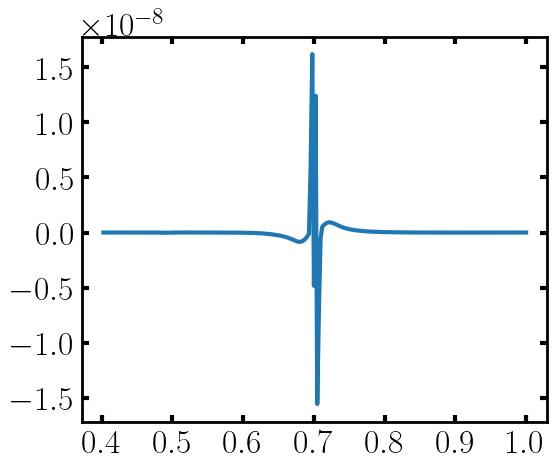

In [125]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    ax.plot(midpts,

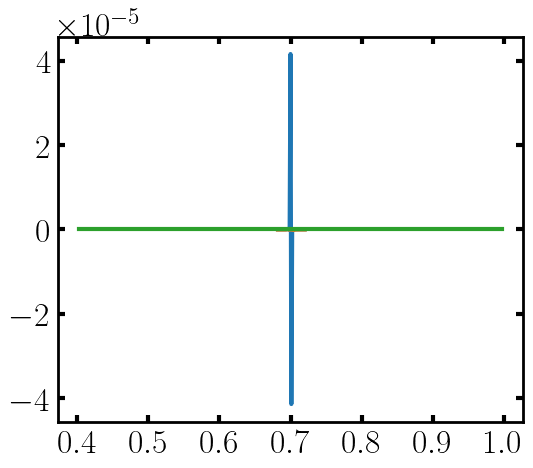

In [122]:
fig

Now need to integrate torque densities to see if close to calculated ones from ppd_cyl.hst?

In [118]:
istart = 0
iend = -1
np.sum(2*np.pi*midpts[istart:iend]*Fy[istart:iend])

3.1766240181691105e-07